In [1]:
import unicodedata
import torch
import torch.nn.functional as F
import torch.nn as nn
import os
import matplotlib.pyplot as plt
from IPython.display import display
import ipywidgets as widgets
from IPython.display import clear_output

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [8]:
ruta_quijote = "../data/Don Quijote de la Mancha.txt"

In [9]:
with open(ruta_quijote, "r", encoding="utf-8") as archivo:
    texto = archivo.read()

# Normalización del texto: quitar acentos y convertir a minúsculas
def limpiar_texto(texto):
    texto = texto.lower()
    texto = unicodedata.normalize("NFKD", texto)
    texto = "".join([c for c in texto if not unicodedata.combining(c)])
    return texto

texto_limpio = limpiar_texto(texto)

# Mostrar primeros 1000
print(texto_limpio[:1000])


capitulo primero. que trata de la condicion y ejercicio del famoso hidalgo
don quijote de la mancha


en un lugar de la mancha, de cuyo nombre no quiero acordarme, no ha mucho
tiempo que vivia un hidalgo de los de lanza en astillero, adarga antigua,
rocin flaco y galgo corredor. una olla de algo mas vaca que carnero,
salpicon las mas noches, duelos y quebrantos los sabados, lantejas los
viernes, algun palomino de anadidura los domingos, consumian las tres
partes de su hacienda. el resto della concluian sayo de velarte, calzas de
velludo para las fiestas, con sus pantuflos de lo mesmo, y los dias de
entresemana se honraba con su vellori de lo mas fino. tenia en su casa una
ama que pasaba de los cuarenta, y una sobrina que no llegaba a los veinte,
y un mozo de campo y plaza, que asi ensillaba el rocin como tomaba la
podadera. frisaba la edad de nuestro hidalgo con los cincuenta anos; era de
complexion recia, seco de carnes, enjuto de rostro, gran madrugador y amigo
de la caza. quieren de

In [10]:
# Obtener caracteres únicos
caracteres = sorted(set(texto_limpio))
print(f"Número de caracteres únicos: {len(caracteres)}")
print(caracteres)

# Crear diccionarios de mapeo
char2idx = {u: i for i, u in enumerate(caracteres)}
idx2char = {i: u for i, u in enumerate(caracteres)}

# Codificar el texto como lista de enteros
texto_codificado = [char2idx[c] for c in texto_limpio]

# Mostrar primeros 20
print(texto_codificado[:20])
print("".join([idx2char[i] for i in texto_codificado[:20]]))


Número de caracteres únicos: 51
['\n', ' ', '!', '"', "'", '(', ')', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', ':', ';', '?', ']', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '¡', '«', '»', '¿']
[24, 22, 36, 30, 40, 41, 32, 35, 1, 36, 38, 30, 33, 26, 38, 35, 9, 1, 37, 41]
capitulo primero. qu


In [11]:

# Convertir a tensor
texto_tensor = torch.tensor(texto_codificado, dtype=torch.long)
seq_length = 100 #tamaño de secuencia
# Crear listas para entradas y etiquetas
x_data = []
y_data = []

for i in range(len(texto_tensor) - seq_length):
    x_data.append(texto_tensor[i:i+seq_length])
    y_data.append(texto_tensor[i+seq_length])

# Convertir a tensores
x_data = torch.stack(x_data)
y_data = torch.tensor(y_data)

print(f"Total de muestras: {len(x_data)}")
print("Ejemplo de entrada (como índices):", x_data[0])
print("Ejemplo de entrada (como texto):", ''.join([idx2char[i.item()] for i in x_data[0]]))
print("Etiqueta esperada:", idx2char[y_data[0].item()])
print("Índice de etiqueta esperada:", y_data[0].item())
print("Etiqueta esperada:", repr(idx2char[y_data[0].item()]))



Total de muestras: 2071098
Ejemplo de entrada (como índices): tensor([24, 22, 36, 30, 40, 41, 32, 35,  1, 36, 38, 30, 33, 26, 38, 35,  9,  1,
        37, 41, 26,  1, 40, 38, 22, 40, 22,  1, 25, 26,  1, 32, 22,  1, 24, 35,
        34, 25, 30, 24, 30, 35, 34,  1, 45,  1, 26, 31, 26, 38, 24, 30, 24, 30,
        35,  1, 25, 26, 32,  1, 27, 22, 33, 35, 39, 35,  1, 29, 30, 25, 22, 32,
        28, 35,  0, 25, 35, 34,  1, 37, 41, 30, 31, 35, 40, 26,  1, 25, 26,  1,
        32, 22,  1, 33, 22, 34, 24, 29, 22,  0])
Ejemplo de entrada (como texto): capitulo primero. que trata de la condicion y ejercicio del famoso hidalgo
don quijote de la mancha

Etiqueta esperada: 

Índice de etiqueta esperada: 0
Etiqueta esperada: '\n'


In [7]:
class ModeloRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers):
        super(ModeloRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden):
        x = self.embedding(x)
        out, hidden = self.rnn(x, hidden)
        out = self.fc(out)
        return out, hidden

In [8]:
vocab_size = len(caracteres)
embedding_dim = 64
hidden_dim = 128
num_layers = 2

modelo = ModeloRNN(vocab_size, embedding_dim, hidden_dim, num_layers).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(modelo.parameters(), lr=0.003)


In [9]:
seq_length = 100
batch_size = 128
epochs = 20

# Preparacion de los datos
def get_batch(data, seq_length, batch_size):
    ix = torch.randint(0, len(data) - seq_length - 1, (batch_size,))
    x_batch = torch.stack([torch.tensor(data[i:i+seq_length]) for i in ix])
    y_batch = torch.stack([torch.tensor(data[i+1:i+seq_length+1]) for i in ix])
    return x_batch.to(device), y_batch.to(device)

for epoch in range(1, epochs + 1):
    modelo.train()
    x_batch, y_batch = get_batch(texto_codificado, seq_length, batch_size)

    hidden = torch.zeros(num_layers, batch_size, hidden_dim).to(device)

    optimizer.zero_grad()
    output, hidden = modelo(x_batch, hidden.detach())

    # Ajuste aquí: hacemos flatten conservando vocab_size para CrossEntropyLoss
    loss = criterion(output.reshape(-1, vocab_size), y_batch.reshape(-1))
    
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch}/{epochs}, Loss: {loss.item():.4f}")


Epoch 1/20, Loss: 3.9162
Epoch 2/20, Loss: 3.6290
Epoch 3/20, Loss: 3.2688
Epoch 4/20, Loss: 3.0260
Epoch 5/20, Loss: 2.9280
Epoch 6/20, Loss: 2.8654
Epoch 7/20, Loss: 2.8217
Epoch 8/20, Loss: 2.7583
Epoch 9/20, Loss: 2.6791
Epoch 10/20, Loss: 2.6154
Epoch 11/20, Loss: 2.5706
Epoch 12/20, Loss: 2.5267
Epoch 13/20, Loss: 2.4997
Epoch 14/20, Loss: 2.4652
Epoch 15/20, Loss: 2.4411
Epoch 16/20, Loss: 2.4044
Epoch 17/20, Loss: 2.4074
Epoch 18/20, Loss: 2.3608
Epoch 19/20, Loss: 2.3313
Epoch 20/20, Loss: 2.3340


In [10]:
os.makedirs("../modelos", exist_ok=True)
ruta_modelo_rnn = "../modelos/modelo_rnn_simple.pth"
torch.save(modelo.state_dict(), ruta_modelo_rnn)
print(f"Modelo guardado en: {ruta_modelo_rnn}")


Modelo guardado en: ../modelos/modelo_rnn_simple.pth


LSTM

In [1]:
import unicodedata
import torch
import torch.nn.functional as F
import torch.nn as nn
import os
import matplotlib.pyplot as plt
from IPython.display import display
import ipywidgets as widgets
from IPython.display import clear_output
from IPython.display import Markdown

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Leer el texto original
ruta_quijote = "../data/Don Quijote de la Mancha.txt"
with open(ruta_quijote, "r", encoding="utf-8") as archivo:
    texto = archivo.read()

# Normalización del texto
def limpiar_texto(texto):
    texto = texto.lower()
    texto = unicodedata.normalize("NFKD", texto)
    texto = "".join([c for c in texto if not unicodedata.combining(c)])
    return texto

texto_limpio = limpiar_texto(texto)

# Guardar texto limpio si no existe
ruta_limpio = "../data/texto_limpio.txt"
if not os.path.exists(ruta_limpio):
    with open(ruta_limpio, "w", encoding="utf-8") as f:
        f.write(texto_limpio)
    print(f"Texto limpio guardado en {ruta_limpio}")
else:
    print(f"El archivo {ruta_limpio} ya existe. No se sobrescribió.")

# Obtener caracteres únicos
caracteres = sorted(set(texto_limpio))

# Guardar caracteres únicos de forma segura
ruta_vocab = "../data/quijote_letras.txt"
if not os.path.exists(ruta_vocab):
    with open(ruta_vocab, "w", encoding="utf-8") as f:
        for c in caracteres:
            f.write(repr(c) + "\n")  # usar repr para evitar ambigüedad
    print(f"Vocabulario guardado en {ruta_vocab}")
else:
    print(f"El archivo {ruta_vocab} ya existe. No se sobrescribió.")

# Leer caracteres únicos de forma segura
with open(ruta_vocab, "r", encoding="utf-8") as f:
    caracteres = [eval(line.strip()) for line in f]

# Crear diccionarios
char2idx = {u: i for i, u in enumerate(caracteres)}
idx2char = {i: u for i, u in enumerate(caracteres)}

# Codificar el texto como lista de enteros
texto_codificado = [char2idx[c] for c in texto_limpio]

# Convertir a tensor
texto_tensor = torch.tensor(texto_codificado, dtype=torch.long)
seq_length = 100  # tamaño de secuencia

# Crear listas para entradas y etiquetas
x_data = []
y_data = []

for i in range(len(texto_tensor) - seq_length):
    x_data.append(texto_tensor[i:i+seq_length])
    y_data.append(texto_tensor[i+seq_length])

# Convertir a tensores finales
x_data = torch.stack(x_data)
y_data = torch.tensor(y_data)


Texto limpio guardado en ../data/texto_limpio.txt
Vocabulario guardado en ../data/quijote_letras.txt


In [3]:
print("Número de caracteres en el vocabulario:", len(caracteres))
print("Primeros 10 caracteres:", caracteres[:10])
print("Longitud del texto limpio tras filtrar:", len(texto_limpio))

Número de caracteres en el vocabulario: 51
Primeros 10 caracteres: ["'\\n'", "' '", "'!'", '\'"\'', '"\'"', "'('", "')'", "','", "'-'", "'.'"]
Longitud del texto limpio tras filtrar: 0


In [2]:
from sklearn.model_selection import train_test_split
import os

# === Leer caracteres únicos desde archivo ===
ruta_vocab = "../data/quijote_letras.txt"
with open(ruta_vocab, "r", encoding="utf-8") as f:
    caracteres = [line[0] for line in f if line.strip() != '']

# Crear diccionarios
char2idx = {u: i for i, u in enumerate(caracteres)}
idx2char = {i: u for i, u in enumerate(caracteres)}

# === Leer texto limpio desde archivo ===
ruta_limpio = "../data/texto_limpio.txt"
with open(ruta_limpio, "r", encoding="utf-8") as f:
    texto_limpio = f.read()

# Filtrar cualquier caracter que no esté en el vocabulario
texto_limpio = ''.join([c for c in texto_limpio if c in char2idx])

# Codificar el texto limpio
texto_codificado = [char2idx[c] for c in texto_limpio]

# División entre entrenamiento y validación
texto_train, texto_valid = train_test_split(texto_codificado, test_size=0.15, random_state=42)

# === Definición del modelo LSTM ===
class ModeloLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.layernorm = nn.LayerNorm(embedding_dim)
        self.dropout = nn.Dropout(0.3)
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=0.3,
            batch_first=True,
            bidirectional=True
        )
        self.fc = nn.Linear(hidden_dim * 2, vocab_size)
        self.dropout_fc = nn.Dropout(0.3)

    def forward(self, x, estados):
        x = self.dropout(self.layernorm(self.embedding(x)))
        salida, estados = self.lstm(x, estados)
        salida = self.dropout_fc(self.fc(salida))
        return salida, estados

# === Función para batches aleatorios ===
def get_batch(data, seq_length, batch_size):
    ix = torch.randint(0, len(data) - seq_length - 1, (batch_size,))
    x_batch = torch.stack([torch.tensor(data[i:i+seq_length]) for i in ix])
    y_batch = torch.stack([torch.tensor(data[i+1:i+seq_length+1]) for i in ix])
    return x_batch.to(device), y_batch.to(device)

# === Hiperparámetros ===
vocab_size = len(caracteres)
embedding_dim = 96
hidden_dim = 128
num_layers = 1
seq_length = 40
batch_size = 128
epochs = 150
steps_per_epoch = 80
val_steps = 10

modelo_lstm = ModeloLSTM(vocab_size, embedding_dim, hidden_dim, num_layers).to(device)
criterion_lstm = nn.CrossEntropyLoss()
optimizer_lstm = torch.optim.AdamW(modelo_lstm.parameters(), lr=0.001, weight_decay=1e-3)

mejor_accuracy = 0.0
patience = 50
patience_counter = 0
ruta_checkpoint = "../modelos/mejor_modelo_lstm.pth"
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# === Entrenamiento con validación ===
for epoch in range(1, epochs + 1):
    modelo_lstm.train()
    train_loss_total = 0
    train_acc_total = 0

    for _ in range(steps_per_epoch):
        x_batch, y_batch = get_batch(texto_train, seq_length, batch_size)
        h0 = torch.zeros(num_layers * 2, batch_size, hidden_dim).to(device)
        c0 = torch.zeros(num_layers * 2, batch_size, hidden_dim).to(device)

        optimizer_lstm.zero_grad()
        output, _ = modelo_lstm(x_batch, (h0.detach(), c0.detach()))
        output = output.view(-1, vocab_size)
        y_batch = y_batch.view(-1)

        loss = criterion_lstm(output, y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(modelo_lstm.parameters(), max_norm=1.5)
        optimizer_lstm.step()

        _, pred = torch.max(output, dim=1)
        acc = (pred == y_batch).float().mean().item()
        train_loss_total += loss.item()
        train_acc_total += acc

    avg_train_loss = train_loss_total / steps_per_epoch
    avg_train_accuracy = train_acc_total / steps_per_epoch
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_accuracy)

    modelo_lstm.eval()
    val_loss_total = 0
    val_acc_total = 0

    with torch.no_grad():
        for _ in range(val_steps):
            x_val, y_val = get_batch(texto_valid, seq_length, batch_size)
            h0_val = torch.zeros(num_layers * 2, batch_size, hidden_dim).to(device)
            c0_val = torch.zeros(num_layers * 2, batch_size, hidden_dim).to(device)

            output_val, _ = modelo_lstm(x_val, (h0_val, c0_val))
            output_val = output_val.view(-1, vocab_size)
            y_val = y_val.view(-1)

            val_loss = criterion_lstm(output_val, y_val)
            _, pred_val = torch.max(output_val, dim=1)
            val_acc = (pred_val == y_val).float().mean().item()

            val_loss_total += val_loss.item()
            val_acc_total += val_acc

    avg_val_loss = val_loss_total / val_steps
    avg_val_accuracy = val_acc_total / val_steps
    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_accuracy)

    print(f"[LSTM] Epoch {epoch}/{epochs}, Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_accuracy:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_accuracy:.4f}")
    
    if avg_val_accuracy > mejor_accuracy:
        mejor_accuracy = avg_val_accuracy
        patience_counter = 0
        torch.save(modelo_lstm.state_dict(), ruta_checkpoint)
        print(f"Nuevo mejor modelo guardado en: {ruta_checkpoint}")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping en época {epoch}")
            break

print(f"Mejor precisión de validación alcanzada: {mejor_accuracy:.4f}")


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[LSTM] Epoch 1/150, Train Loss: 1.2482, Train Acc: 0.6570, Val Loss: 0.0282, Val Acc: 0.9953
Nuevo mejor modelo guardado en: ../modelos/mejor_modelo_lstm.pth
[LSTM] Epoch 2/150, Train Loss: 0.8496, Train Acc: 0.7074, Val Loss: 0.0156, Val Acc: 0.9952
[LSTM] Epoch 3/150, Train Loss: 0.8465, Train Acc: 0.7095, Val Loss: 0.0139, Val Acc: 0.9951
[LSTM] Epoch 4/150, Train Loss: 0.8388, Train Acc: 0.7120, Val Loss: 0.0133, Val Acc: 0.9951
[LSTM] Epoch 5/150, Train Loss: 0.8402, Train Acc: 0.7114, Val Loss: 0.0142, Val Acc: 0.9945
[LSTM] Epoch 6/150, Train Loss: 0.8435, Train Acc: 0.7101, Val Loss: 0.0138, Val Acc: 0.9945
[LSTM] Epoch 7/150, Train Loss: 0.8399, Train Acc: 0.7112, Val Loss: 0.0134, Val Acc: 0.9946
[LSTM] Epoch 8/150, Train Loss: 0.8385, Train Acc: 0.7119, Val Loss: 0.0139, Val Acc: 0.9945
[LSTM] Epoch 9/150, Train Loss: 0.8399, Train Acc: 0.7110, Val Loss: 0.0137, Val Acc: 0.9946
[LSTM] Epoch 10/150, Train Loss: 0.8415, Train Acc: 0.7103, Val Loss: 0.0130, Val Acc: 0.9951
[LST

In [3]:
# Carga desde checkpoint y evalúa
modelo_lstm = ModeloLSTM(vocab_size, embedding_dim, hidden_dim, num_layers).to(device)
modelo_lstm.load_state_dict(torch.load("../modelos/mejor_modelo_lstm.pth"))
modelo_lstm.eval()

# Evaluación sobre conjunto de validación
val_steps = 50
val_loss_total = 0
val_accuracy_total = 0

with torch.no_grad():
    for _ in range(val_steps):
        x_val, y_val = get_batch(texto_valid, seq_length, batch_size)
        h0_val = torch.zeros(num_layers * 2, batch_size, hidden_dim).to(device)
        c0_val = torch.zeros(num_layers * 2, batch_size, hidden_dim).to(device)

        output_val, _ = modelo_lstm(x_val, (h0_val, c0_val))
        output_val = output_val.view(-1, vocab_size)
        y_val = y_val.reshape(-1)

        loss_val = criterion_lstm(output_val, y_val)
        val_loss_total += loss_val.item()

        _, pred_val = torch.max(output_val, dim=1)
        acc_val = (pred_val == y_val).float().mean().item()
        val_accuracy_total += acc_val

avg_val_loss = val_loss_total / val_steps
avg_val_acc = val_accuracy_total / val_steps

print(f"Validación del modelo guardado — Loss: {avg_val_loss:.4f}, Accuracy: {avg_val_acc:.4f}")


Validación del modelo guardado — Loss: 0.0091, Accuracy: 0.9971


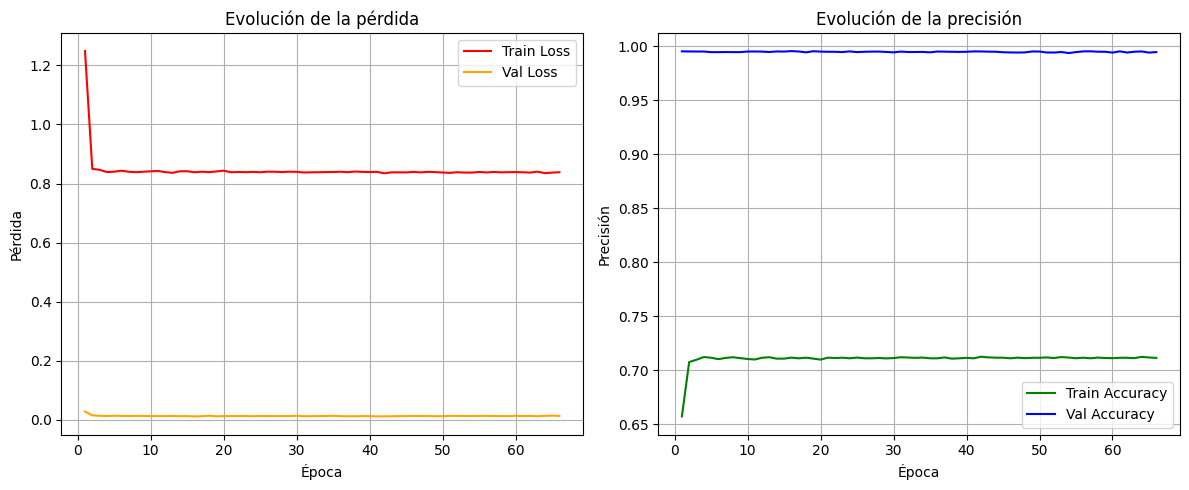

In [3]:
plt.figure(figsize=(12, 5))

# Gráfico de pérdida
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss", color='red')
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Val Loss", color='orange')
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.title("Evolución de la pérdida")
plt.legend()
plt.grid(True)

# Gráfico de precisión
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label="Train Accuracy", color='green')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label="Val Accuracy", color='blue')
plt.xlabel("Época")
plt.ylabel("Precisión")
plt.title("Evolución de la precisión")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [2]:
import torch
import torch.nn as nn
import ipywidgets as widgets
from IPython.display import display, clear_output, Markdown

# Configuración del dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Cargar vocabulario desde archivo
ruta_vocab = "../data/quijote_letras.txt"
with open(ruta_vocab, "r", encoding="utf-8") as f:
    caracteres = [line.strip() for line in f.readlines()]

vocab_size = len(caracteres)
char2idx = {ch: idx for idx, ch in enumerate(caracteres)}
idx2char = {idx: ch for ch, idx in char2idx.items()}

# Definir parámetros usados en entrenamiento
seq_length = 40
embedding_dim = 96
hidden_dim = 128
num_layers = 1
longitud_a_generar = 50

# Definición del modelo (idéntico al usado en entrenamiento)
class ModeloLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.layernorm = nn.LayerNorm(embedding_dim)
        self.dropout = nn.Dropout(0.3)
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=0.3,
            batch_first=True,
            bidirectional=True
        )
        self.fc = nn.Linear(hidden_dim * 2, vocab_size)
        self.dropout_fc = nn.Dropout(0.3)

    def forward(self, x, estados):
        x = self.dropout(self.layernorm(self.embedding(x)))
        salida, estados = self.lstm(x, estados)
        salida = self.dropout_fc(self.fc(salida))
        return salida, estados

# Cargar el modelo entrenado
modelo_lstm = ModeloLSTM(vocab_size, embedding_dim, hidden_dim, num_layers).to(device)
modelo_lstm.load_state_dict(torch.load("../modelos/mejor_modelo_lstm.pth"))
modelo_lstm.eval()


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


ModeloLSTM(
  (embedding): Embedding(51, 96)
  (layernorm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (lstm): LSTM(96, 128, batch_first=True, dropout=0.3, bidirectional=True)
  (fc): Linear(in_features=256, out_features=51, bias=True)
  (dropout_fc): Dropout(p=0.3, inplace=False)
)

In [3]:
from IPython.display import Markdown
# Diccionarios de conversión
char2idx = {ch: idx for idx, ch in enumerate(caracteres)}
idx2char = {idx: ch for ch, idx in char2idx.items()}

# Clase ModeloLSTM exactamente como la usada en entrenamiento
class ModeloLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.layernorm = nn.LayerNorm(embedding_dim)
        self.dropout = nn.Dropout(0.3)
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=0.3,
            batch_first=True,
            bidirectional=True
        )
        self.fc = nn.Linear(hidden_dim * 2, vocab_size)
        self.dropout_fc = nn.Dropout(0.3)

    def forward(self, x, estados):
        x = self.dropout(self.layernorm(self.embedding(x)))
        salida, estados = self.lstm(x, estados)
        salida = self.dropout_fc(self.fc(salida))
        return salida, estados

# Cargar modelo entrenado
modelo_lstm = ModeloLSTM(vocab_size, embedding_dim, hidden_dim, num_layers).to(device)
modelo_lstm.load_state_dict(torch.load("../modelos/mejor_modelo_lstm.pth"))
modelo_lstm.eval()

# Parámetros
longitud_a_generar = 50

# Crear widgets
texto_input = widgets.Text(
    value='',
    placeholder='Escribe el texto inicial',
    description='Inicio:',
    layout=widgets.Layout(width='80%')
)

boton_generar = widgets.Button(description="Generar texto", button_style='success')
salida = widgets.Output(layout={'border': '1px solid black', 'width': '100%', 'overflow_x': 'auto'})

# Función de generación
def generar_texto(b):
    entrada_usuario = texto_input.value.lower()

    with salida:
        clear_output()
        if not entrada_usuario.strip():
            print("Ingresa un texto válido.")
            return

        entrada = [char2idx[c] for c in entrada_usuario if c in char2idx]
        while len(entrada) < seq_length:
            entrada.insert(0, char2idx.get(' ', list(char2idx.values())[0]))

        h = torch.zeros(num_layers * 2, 1, hidden_dim).to(device)
        c = torch.zeros(num_layers * 2, 1, hidden_dim).to(device)

        modelo_lstm.eval()
        temperature = 1.2  # Ajusta según necesidad

        for _ in range(longitud_a_generar):
            input_tensor = torch.tensor(entrada[-seq_length:], dtype=torch.long).unsqueeze(0).to(device)
            with torch.no_grad():
                output, (h, c) = modelo_lstm(input_tensor, (h, c))
                logits = output[:, -1, :].squeeze() / temperature
                probas = torch.softmax(logits, dim=-1)
                siguiente_indice = torch.multinomial(probas, num_samples=1).item()
                entrada.append(siguiente_indice)

        texto_generado = ''.join([idx2char.get(idx, '?') for idx in entrada])
        display(Markdown(f"**=== TEXTO GENERADO ===**\n\n```\n{texto_generado}\n```"))

# Conectar botón
boton_generar.on_click(generar_texto)

# Mostrar todo junto
display(widgets.VBox([texto_input, boton_generar, salida]))
